In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [6]:
FORECAST = 5
LAG = 12
EPS = 120
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = Routes('train', 32, lag=LAG).generator()
evalset = Routes('test', 32, lag=LAG).generator()

Routes dataset: train
 [*] Loaded routes: 242 (0.37s)
 [*] Subset train: 222 (reserved_routes.json)
 [*] Loaded trainable inds: 188412 (0.29s)
Routes dataset: test
 [*] Loaded routes: 242 (1.01s)
 [*] Subset test: 20 (reserved_routes.json)
 [*] Loaded trainable inds: 44919 (0.02s)


In [5]:
from models.temporal.Cast import Cast

In [7]:
model = Cast(forecast=FORECAST, hidden_size=256, deep=DEEP, lag=LAG).to(device)
model.device = device

In [8]:
criterion, opt, sch = model.params(lr=0.001)

In [9]:
evaluate(evalset, model, criterion)

Eval loss: 34.52525749709192


In [ ]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 5888/5888] - L0.19         
Eval loss: 5.387943369555327
[2/120 : 5888/5888] - L0.09         
Eval loss: 5.063741937580855
[3/120 : 5888/5888] - L0.09         
Eval loss: 4.810005617955503
[4/120 : 5888/5888] - L0.04         
Eval loss: 4.524603394759644
[5/120 : 5888/5888] - L0.28         
Eval loss: 4.281876815437867


In [15]:
# torch.save(model.state_dict(), 'checkpoints/tmp_rnn_short.pth')

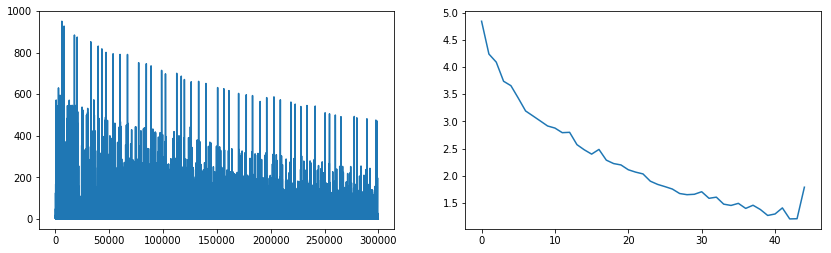

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

4


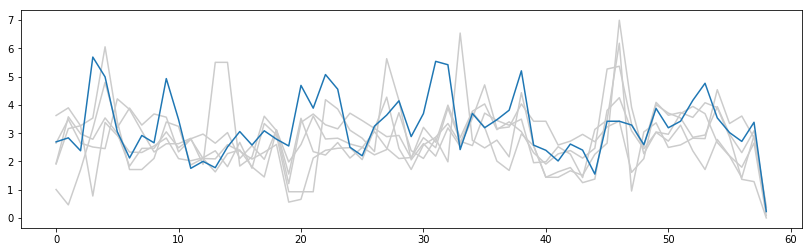

In [11]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
# print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
# sample = hist_smooth(sample)
print(np.count_nonzero(np.isnan(sample)))
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [13]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = torch.Tensor(np.expand_dims(sample[:, bi-10:bi], 0))
    Xs, _ = model.format_batch(hist)
    yout = model(Xs)
    preds.append(tonpy(yout))

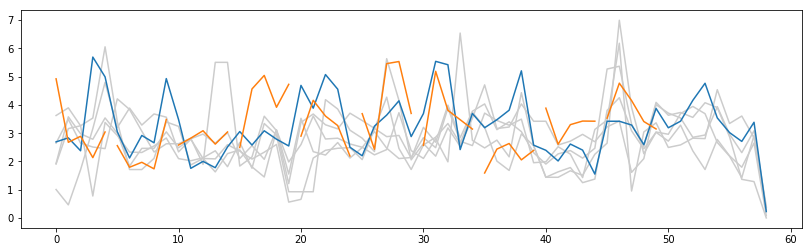

In [14]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 5):
    ylast = np.flip(preds[bi-10][0, :])
    xpos = list(range(bi-10, bi-5))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()